# EMCal Clustering Studies in DarkQuest
document the code for studing the emcal clustering in DarkQuest

In [1]:
class EMCal(object):
    """
    define the EMCal Geometry
    """
    def __init__(self):
        self.ntowersx=72
        self.ntowersy=36
        self.sizex=5.53 # in cm
        self.sizey=5.53 # in cm

        self.ecalx=[-200,200] #size in cm
        self.ecaly=[-100,100]
        self.binsx=self.ecalx[1]- self.ecalx[0]
        self.binsy=self.ecaly[1]- self.ecaly[0]

In [189]:
import uproot3
import numpy as np
import numba
import awkward1 as ak
import awkward as ak0

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd
from scipy.stats import halfnorm

class EMClustering(object):
    """
    defines the EMCal clustering algorithm and the performance
    """
    def __init__(self, cells_x, cells_y, cells_e, ge, ifile="sim_eval_Brem_0.033428_z500_600_eps_-5.2.root", evtNum=0):
        # x, y and energy information of the cells
        # in np array
        self.cells_x = cells_x
        self.cells_y = cells_y
        self.cells_e = cells_e
        
        # electron energy
        self.ge = ge
        
        self.Mass=ifile.split("/")[-1].split("_")[3]+" GeV"
        self.Type=ifile.split("/")[-1].split("_")[2]
        self.evtNum = evtNum
        
        self.emcal = EMCal()
        
    def plotCount(self):
        # Plot x and y from towers
        fig = plt.figure(figsize=(8,6))
        plt.hist2d(np.array(self.cells_x),np.array(self.cells_y), bins=[int(self.emcal.binsx/self.emcal.sizex),int(self.emcal.binsy/self.emcal.sizey)], range=[self.emcal.ecalx,self.emcal.ecaly], density=False, norm=colors.LogNorm())
        plt.xlabel("Tower x")
        plt.ylabel("Tower y")
        cbar=plt.colorbar()
        cbar.set_label('Counts')
        plt.title("Unweighted Counts for "+self.Type+": "+self.Mass+" \n Event "+str(self.evtNum))
        plt.show()
        
    def plotEnergy(self):
        # weighted
        fig = plt.figure(figsize=(8,6))
        emcal = EMCal()
        plt.hist2d(np.array(self.cells_x),np.array(self.cells_y), bins=[int(self.emcal.binsx/self.emcal.sizex),int(self.emcal.binsy/self.emcal.sizey)], range=[self.emcal.ecalx,self.emcal.ecaly], weights=np.array(self.cells_e)*1e3, density=False, norm=colors.LogNorm())
        plt.xlabel("EMCal X [cm]")
        plt.ylabel("EMCal Y [cm]")
        cbar=plt.colorbar()
        cbar.set_label('Energy Deposit [MeV]')
        #plt.title("Energy Deposits for "+self.Type+": "+self.Mass+" \n Event "+str(self.evtNum))
        plt.show()
        
    def performClustering(self, algo = 0, makePlot = False):
        X = np.vstack((np.array(self.cells_x), np.array(self.cells_y))).T
        #print("")
        #print(""*30)
        #print("Perform Clustering...")
        funcNames = {}
        funcNames[0] = "BirchClustering"
        funcNames[1] = "KMeansClustering"
        labels = getattr(self, funcNames[algo])(X)
        if len(labels)==2:
            labels, centers = labels[0], labels[1]
        
        clusters = np.unique(labels)
        energies = np.zeros(clusters.shape[0])
        sizes = np.zeros(clusters.shape[0])
        icluster = 0
        for cluster in clusters:
            # get row indexes for samples with this cluster
            row_ix = np.where(labels == cluster)
            energies[icluster] = np.sum(self.cells_e[row_ix])
            sizes[icluster] = np.sum(self.cells_e[row_ix]>0)
            icluster += 1
            
        # show the plot
        if makePlot:
            # create scatter plot for samples from each cluster
            fig = plt.figure(figsize=(8,6))
            for cluster in clusters:
                # get row indexes for samples with this cluster
                row_ix = np.where(labels == cluster)
                # create scatter of these samples
                plt.scatter(X[row_ix, 0], X[row_ix, 1])
            plt.xlabel("EMCal X [cm]")
            plt.ylabel("EMCal Y [cm]")
            plt.xlim(self.emcal.ecalx[0],self.emcal.ecalx[1])
            plt.ylim(self.emcal.ecaly[0],self.emcal.ecaly[1])
            plt.show()    
    
        #print("number of clusters after Birch clustering: ", clusters.shape[0])
        #print("number of cells with energy deposits:", np.sum(self.cells_e>0))
        #print("energy of the clusters: ", energies)
        #print("truth deposits: ", self.ge)
        #print("size of the clusters: ", sizes)
        #print("Finished Birch Clustering...")
        #print("*"*50)
        return energies, sizes
        
    def BirchClustering(self, X):
        # try birch clusters without considering weights by energy
        from sklearn.cluster import Birch
        from sklearn.mixture import GaussianMixture
        brc = Birch(n_clusters=2)
        brc.fit(X)
        labels = brc.predict(X)
        return labels
        
    def KMeansClustering(self, X):
        # try kmeans clusters with energy weights
        energy_weights = np.divide(np.array(self.cells_e),np.max(self.cells_e))
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000)
        Y = energy_weights
        wt_kmeansclus = kmeans.fit(X, sample_weight = Y)
        return wt_kmeansclus.labels_, wt_kmeansclus.cluster_centers_

In [3]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot3.open(fname)["Truth"].arrays()
    dq_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in dq_dict.items()}
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict_ak1["hit_detID"],
                                      "edep":    dq_dict_ak1["hit_edep"],
                                      "elmID":   dq_dict_ak1["hit_elmID"],
                                      "truthx":  dq_dict_ak1["hit_truthx"],
                                      "truthy":  dq_dict_ak1["hit_truthy"],
                                      "truthz":  dq_dict_ak1["hit_truthz"],
                                      }),
                        "Electrons":ak.zip({
                                            "ge":      dq_dict_ak1["ge"],
                                        }),
                        "Showers": ak.zip({
                                            "nshowers": dq_dict_ak1["n_showers"],
                                            "sedep_ecal": dq_dict_ak1["sedep_ecal"],
                                        }),
                       }, depth_limit=1)
    return dq_events

In [4]:
def emcal_selection(arr):
    mask = (arr.detID == 100)
    return mask

def emcal_energy_selection(arr, e):
    mask = (arr.edep >= e)
    return mask

def h2_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 38)
    return mask

def st2_selection(arr):
    mask = (arr.detID >= 13) & (arr.detID <= 18)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h4_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 46)
    return mask

In [5]:
def printemcalhits_byevent(ifile):
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events["Hits"]
    ecal_mask = ak.any(dq_hits.detID == 100, axis=1)
    ecal_index = np.where(ecal_mask)
    print('Fraction of events with hits reaching EMCAL: ',len(ecal_index[0])/len(dq_events))
    print("Let's print the evt numbers we can use to plot EMCAL clusters")
    print('Indices of evts w. EMCAL hits:',ecal_index)
    return ecal_index

In [27]:
def printemcalshowers_byevent(ifile):
    dq_events = getData(ifile,"Truth")
    dq_showers = dq_events["Showers"]
    ecal_mask = ak.any(dq_showers.nshowers == 2,axis=1) & ak.all(dq_showers.sedep_ecal > 0, axis=1)
    #ecal_mask = ak.all(dq_showers.sedep_ecal > 0, axis=1)
    ecal_index = np.where(ecal_mask)
    print('Fraction of events with \x1b[31mTWO\033[0m showers reaching EMCAL: ',len(ecal_index[0])/len(dq_events))
    print("Let's print the evt numbers we can use to plot EMCAL clusters")
    print('Indices of evts w. EMCAL hits:',ecal_index)
    return ecal_index[0]

In [190]:
def CheckEvent(ifile, evtNum):
    #print("filename ", ifile)
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events[evtNum]["Hits"]
    dq_electrons = dq_events[evtNum]["Electrons"]
    dq_showers = dq_events[evtNum]["Showers"]
    
    ge = dq_electrons.ge
    showers = dq_showers.sedep_ecal
    #print("electron energy: ", ge)
    #print("showers: ", showers)
    
    # select emcal hits
    emcal_mask = emcal_selection(dq_hits)
    emcal_hits = dq_hits[emcal_mask]
    emcal_energy_mask = emcal_energy_selection(emcal_hits, 0.0005)
    emcal_hits = emcal_hits[emcal_energy_mask]
    
    emcal = EMCal()
    emcal_towerx = emcal_hits.elmID//emcal.ntowersy
    emcal_towery = emcal_hits.elmID%emcal.ntowersy
    emcal_truthx = emcal_hits.truthx
    emcal_truthy = emcal_hits.truthy
    emcal_x = emcal.ecalx[0]+emcal_towerx*emcal.sizex
    emcal_y = emcal.ecaly[0]+emcal_towery*emcal.sizey
    emcal_edep = emcal_hits.edep
    
    #st3_mask = st3_selection(dq_hits)
    #st3_hits = dq_hits[st3_mask]

    #st2_mask = st2_selection(dq_hits)
    #st2_hits = dq_hits[st2_mask]
    #st2_truthx = st2_hits.truthx
    #st2_truthy = st2_hits.truthy
    
    #h2_mask = h2_selection(dq_hits)
    #h2_hits = dq_hits[h2_mask]
    
    #print("St3 hits %i, St2 hits %i, H2 hits %i"%(len(st3_hits),len(st2_hits),len(h2_hits)))
    #print("Event "+str(evtNum)+": "+str(len(emcal_hits))+" hits")
    
    clustering = EMClustering(emcal_x, emcal_y, emcal_edep, ge, ifile, evtNum)
    #clustering.plotCount()
    clustering.plotEnergy()
    energies, sizes = clustering.performClustering(makePlot=True)
    
    return ge, showers, energies, sizes

Fraction of events with TWO showers reaching EMCAL:  0.2784473313507591
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [4, 5, 7, 12, ... 6381, 6383, 6388] type='1779 * int64'>,)
1779
electron energy:  [[3.36, 9.6], [17.6, 4.53], [11.6, 10.5], ... 7.93, 9.84], [6.76, 11], [21.5, 0.625]]
showers:  [[0.166, 1.13], [2.06, 0.552], [1.39, ... 1.14], [0.801, 1.26], [2.46, 0.000484]]
emcal_hits [0.00108, 0.00115, 0.0242, 0.0698, ... 0.000317, 0.00179, 0.000549, 0.000484]


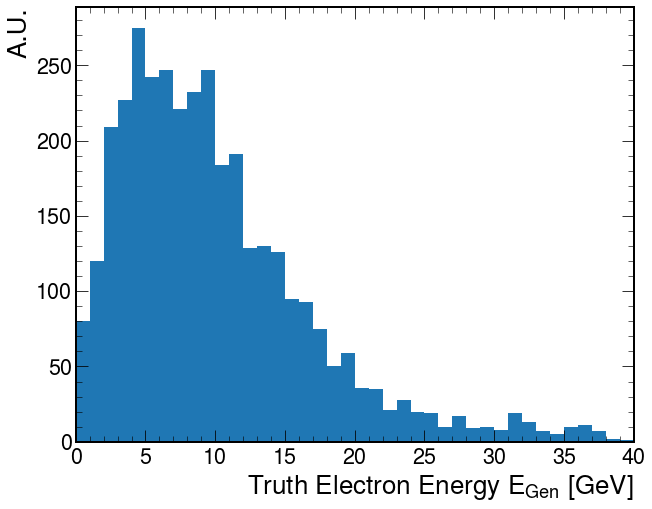

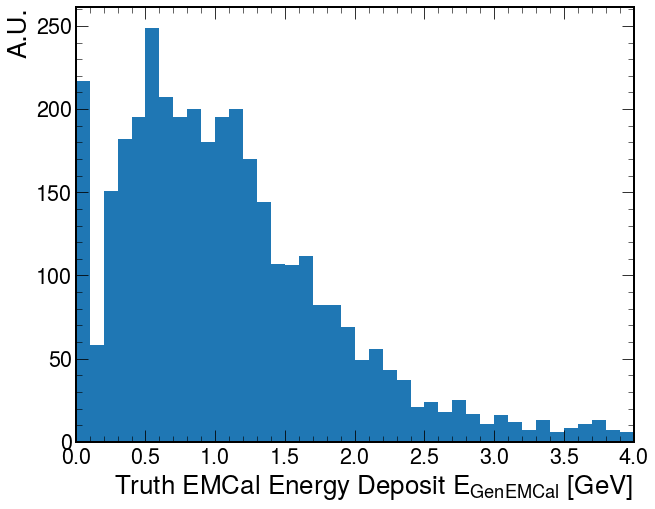

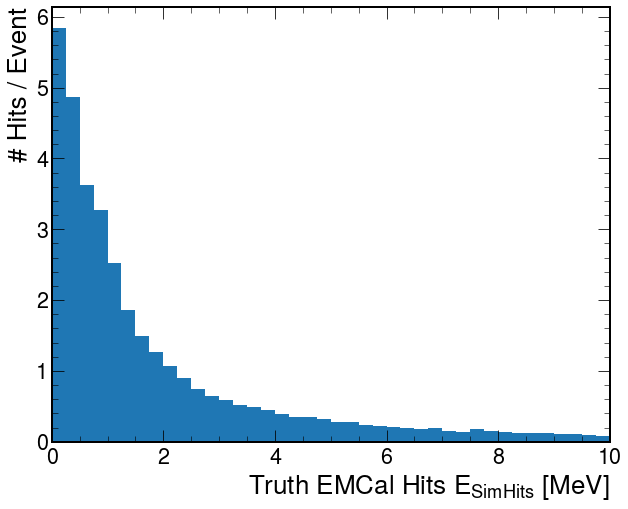

In [180]:
def plotQuantities(ifile):
    #print("filename ", ifile)
    events=printemcalshowers_byevent(ifile)
    print(len(events))
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events[events]["Hits"]
    dq_electrons = dq_events[events]["Electrons"]
    dq_showers = dq_events[events]["Showers"]
    
    ge = dq_electrons.ge
    showers = dq_showers.sedep_ecal
    print("electron energy: ", ge)
    print("showers: ", showers)
    
    # select emcal hits
    emcal_mask = emcal_selection(dq_hits)
    emcal_hits = dq_hits[emcal_mask]
    #emcal_energy_mask = emcal_energy_selection(emcal_hits, 0.0005)
    #emcal_hits = emcal_hits[emcal_energy_mask]
    print("emcal_hits", ak.flatten(emcal_hits.edep,axis=None))
    
    fig = plt.figure(figsize=(10,8))
    plt.hist(ak.flatten(ge,axis=None), bins=40, range=(0,40), density=False)
    plt.xlim(0,40)
    plt.xlabel("Truth Electron Energy $E_{Gen}$ [GeV]")
    plt.ylabel('A.U.')
    plt.savefig("truth_electron_energy.png")
    #plt.ylim(0,8)
    #cbar=plt.colorbar()
    
    fig = plt.figure(figsize=(10,8))
    plt.hist(ak.flatten(showers,axis=None), bins=40, range=(0,4), density=False)
    plt.xlim(0,4)
    plt.xlabel("Truth EMCal Energy Deposit $E_{Gen EMCal}$ [GeV]")
    plt.ylabel('A.U.')
    plt.savefig("truth_emcal_energy.png")
    
    fig = plt.figure(figsize=(10,8))
    plt.hist(ak.flatten(emcal_hits*1000,axis=None), bins=40, range=(0,10), density=False, weights=1.0/len(events)*np.ones(len(ak.flatten(emcal_hits*1000,axis=None))))
    plt.xlim(0,10)
    plt.xlabel("Truth EMCal Hits $E_{Sim Hits}$ [MeV]")
    plt.ylabel('# Hits / Event')
    plt.savefig("emcal_simhits.png")
    
    
    
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.033428_z500_600_eps_-6.root"
plotQuantities(ifileBrem)

Fraction of events with TWO showers reaching EMCAL:  0.2784473313507591
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [4, 5, 7, 12, ... 6381, 6383, 6388] type='1779 * int64'>,)
acc:  [4, 5, 7, 12, 15, 18, 20, 21, 22, ... 6363, 6365, 6368, 6369, 6373, 6381, 6383, 6388] 1779


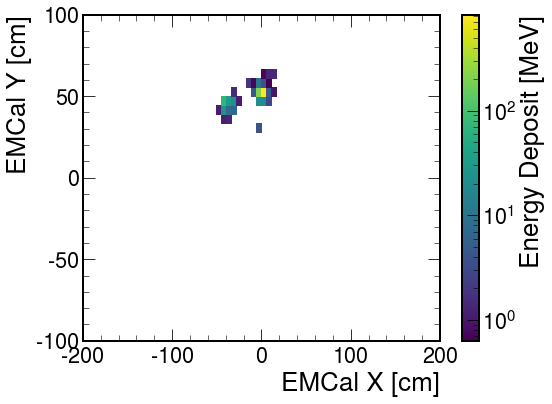

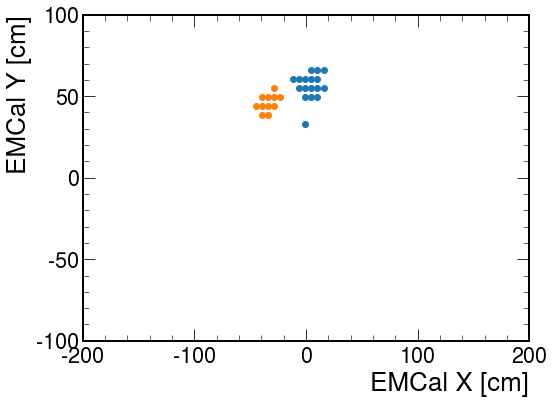

ge [3.36, 9.6]
showers [0.166, 1.13]
energies [1.12814164 0.16828471]
sizes [17. 11.]


In [193]:
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.033428_z500_600_eps_-6.root"
# this prints the evt numbers w two emcal showers and returns basic acceptance
acc = printemcalshowers_byevent(ifileBrem)
print("acc: ", acc, len(acc))

for evt in acc:
    if evt != 4:
        continue
    #evt = acc[ievt] 
    ge, showers, energies, sizes = CheckEvent(ifileBrem,evt)
    print("ge", ge)
    print("showers", showers)
    print("energies", energies)
    print("sizes", sizes)
    

In [8]:
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.033428_z500_600_eps_-6.root"
# this prints the evt numbers w two emcal showers and returns basic acceptance
acc = printemcalshowers_byevent(ifileBrem)
print("acc: ", acc, len(acc))
# this reconstructs preliminary clusters
electron_truth_max = [] # electron truth energy from production
electron_truth_min = []
cluster_truth_max = []
cluster_truth_min = []
cluster_reco_max = []
cluster_reco_min = []
cluster_size_max = []
cluster_size_min = []

for evt in acc:
    #if evt > 100:
    #    continue
    #evt = acc[ievt] 
    if len(cluster_size_max)%10 == 0:
        print("processed ", len(cluster_size_max), "events")
    ge, showers, energies, sizes = CheckEvent(ifileBrem,evt)
    #print("electron energies: ", ge)
    #print("showers: ", showers)
    #print("energies: ", energies)
    #print("sizes: ", sizes)
    electron_truth_max.append(max(ge))
    electron_truth_min.append(min(ge))
    cluster_truth_max.append(max(showers))
    cluster_truth_min.append(min(showers))
    cluster_reco_max.append(max(energies))
    cluster_reco_min.append(min(energies))
    cluster_size_max.append(sizes[np.argmax(energies)])
    cluster_size_min.append(sizes[np.argmin(energies)])
    #print("truth cluster: ", cluster_truth)
    #print("reco cluster: ", cluster_reco)
    #print("size cluster ", cluster_size)
    #break

Fraction of events with two showers reaching EMCAL:  0.2784473313507591
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [4, 5, 7, 12, ... 6381, 6383, 6388] type='1779 * int64'>,)
acc:  [4, 5, 7, 12, 15, 18, 20, 21, 22, ... 6363, 6365, 6368, 6369, 6373, 6381, 6383, 6388] 1779
processed  0 events
processed  10 events
processed  20 events
processed  30 events
processed  40 events
processed  50 events
processed  60 events
processed  70 events
processed  80 events
processed  90 events
processed  100 events
processed  110 events


/seaquest/users/yfeng/anaconda3/envs/emcluster/lib/python3.8/site-packages/sklearn/cluster/_birch.py:646: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  warnings.warn(


processed  120 events
processed  130 events
processed  140 events
processed  150 events
processed  160 events
processed  170 events
processed  180 events
processed  190 events
processed  200 events
processed  210 events
processed  220 events
processed  230 events
processed  240 events
processed  250 events
processed  260 events
processed  270 events
processed  280 events
processed  290 events
processed  300 events
processed  310 events
processed  320 events
processed  330 events
processed  340 events
processed  350 events
processed  360 events
processed  370 events
processed  380 events
processed  390 events
processed  400 events
processed  410 events
processed  420 events
processed  430 events
processed  440 events
processed  450 events
processed  460 events
processed  470 events
processed  480 events
processed  490 events
processed  500 events
processed  510 events
processed  520 events
processed  530 events
processed  540 events
processed  550 events
processed  560 events
processed 

/seaquest/users/yfeng/anaconda3/envs/emcluster/lib/python3.8/site-packages/sklearn/cluster/_birch.py:646: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  warnings.warn(


processed  750 events
processed  760 events
processed  770 events
processed  780 events
processed  790 events
processed  800 events
processed  810 events
processed  820 events
processed  830 events
processed  840 events
processed  850 events
processed  860 events
processed  870 events
processed  880 events
processed  890 events
processed  900 events
processed  910 events
processed  920 events
processed  930 events
processed  940 events
processed  950 events
processed  960 events
processed  970 events
processed  980 events
processed  990 events
processed  1000 events
processed  1010 events
processed  1020 events
processed  1030 events
processed  1040 events
processed  1050 events
processed  1060 events
processed  1070 events
processed  1080 events
processed  1090 events
processed  1100 events
processed  1110 events
processed  1120 events
processed  1130 events
processed  1140 events
processed  1150 events
processed  1160 events
processed  1170 events
processed  1180 events
processed  11

In [ ]:
cluster_energy_array = np.array(cluster_reco_max+cluster_reco_min)
electron_truth_energy_array = np.array(electron_truth_max+electron_truth_min)
mask_outliers = np.where(cluster_energy_array>0.05*electron_truth_energy_array)
cluster_energy_array = cluster_energy_array[mask_outliers]
electron_truth_energy_array = electron_truth_energy_array[mask_outliers]

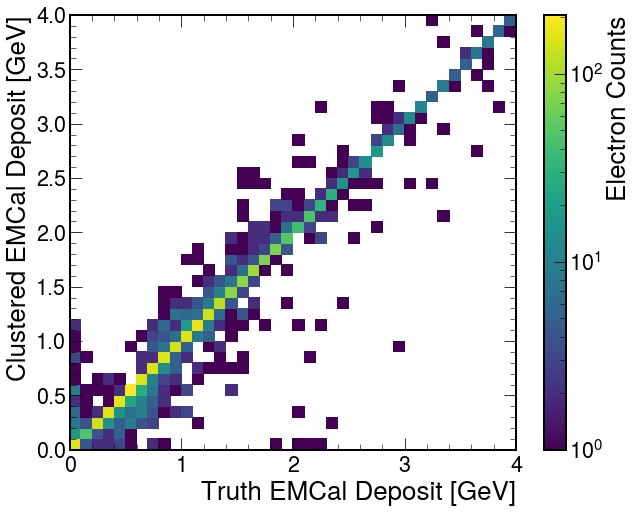

In [195]:
fig = plt.figure(figsize=(10,8))
plt.hist2d(cluster_truth_max+cluster_truth_min, cluster_reco_max+cluster_reco_min, bins=[40,40], range=[[0,4], [0,4]], density=False, norm=colors.LogNorm())
#plt.xlim(0,8)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth EMCal Deposit [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_Gen_Energy_large.png")

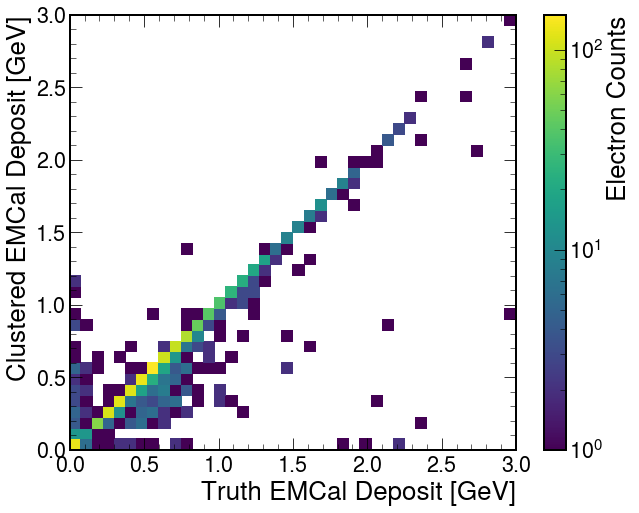

In [10]:
fig = plt.figure(figsize=(10,8))
plt.hist2d(cluster_truth_min, cluster_reco_min, bins=[40,40], range=[[0,3], [0,3]], density=False, norm=colors.LogNorm())
#plt.xlim(0,8)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth EMCal Deposit [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_Gen_Energy_small.png")

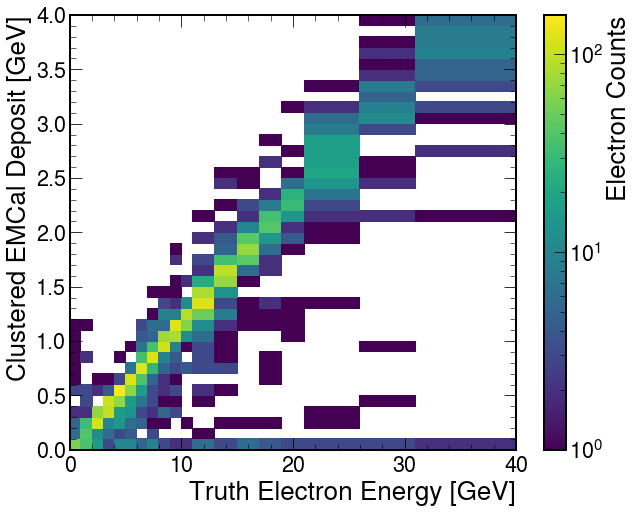

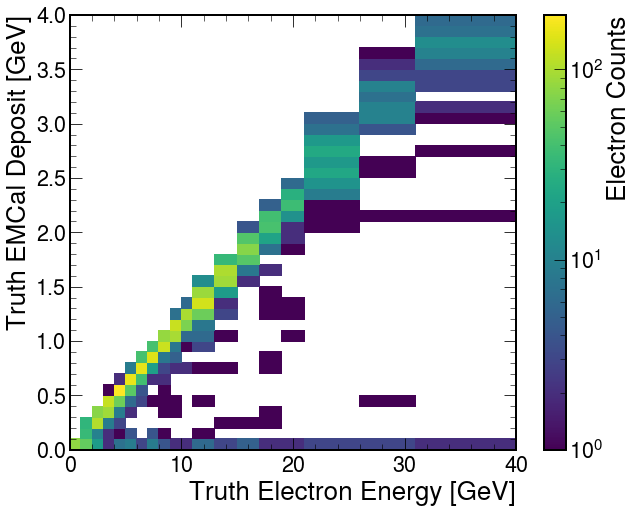

In [199]:
fig = plt.figure(figsize=(10,8))
plt.hist2d(electron_truth_max+electron_truth_min, cluster_reco_max+cluster_reco_min, bins=[binnings,40], range=[[0,40], [0,4]], density=False, norm=colors.LogNorm())
plt.xlim(0,40.0)
plt.ylim(0,4.0)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_GenElectron_Energy.png")

fig = plt.figure(figsize=(10,8))
plt.hist2d(electron_truth_max+electron_truth_min, cluster_truth_max+cluster_truth_min, bins=[binnings,40], range=[[0,40], [0,4]], density=False, norm=colors.LogNorm())
plt.xlim(0,40.0)
plt.ylim(0,4.0)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Truth EMCal Deposit [GeV]")
plt.savefig("Truth_VS_GenElectron_Energy.png")

In [117]:
# event cleaning
cluster_energy_array = np.array(cluster_reco_max+cluster_reco_min)
electron_truth_energy_array = np.array(electron_truth_max+electron_truth_min)
mask_outliers = np.where(cluster_energy_array>0.05*electron_truth_energy_array)
cluster_energy_array = cluster_energy_array[mask_outliers]
electron_truth_energy_array = electron_truth_energy_array[mask_outliers]

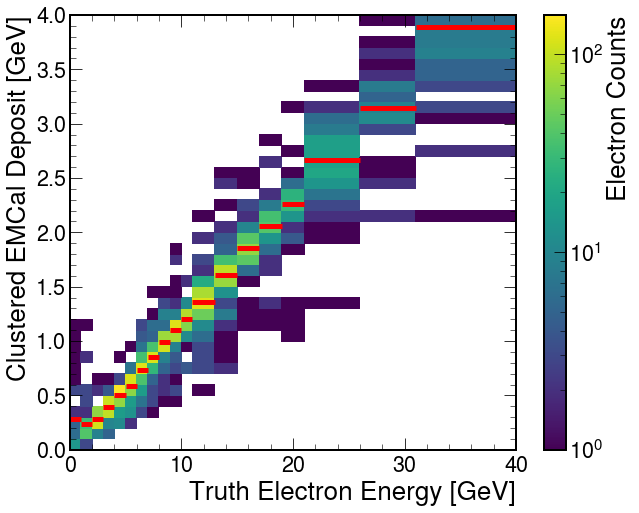

In [204]:
#print(electron_truth)
from scipy.stats import binned_statistic
fig = plt.figure(figsize=(10,8))
binnings = np.concatenate((np.linspace(0,10,num=11), np.linspace(11,19,num=5),np.linspace(21,31,num=3), np.linspace(41, 51, num=2)))
bin_resols, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_energy_array, statistic='std', bins=binnings, range=(0,40))
bin_means, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_energy_array, statistic='mean', bins=binnings, range=(0,40))
plt.hist2d(electron_truth_energy_array, cluster_energy_array, bins=[binnings,40], range=[[0,40], [0,4]], density=False, norm=colors.LogNorm())
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.xlim(0,40)
plt.ylim(0,4)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_GenElectron_Energy.png")

[0.27935287 0.23528227 0.28318504 0.39309083 0.50089064 0.59108962
 0.7372987  0.85417158 0.99064568 1.10147352 1.20193899 1.35615394
 1.61128868 1.85782673 2.05612362 2.25798202 2.66408155 3.1412314
 3.891529   5.30514283]
[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 12.0, 14.0, 16.0, 18.0, 20.0, 23.5, 28.5, 36.0, 46.0]


Text(0, 1, '$\\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')

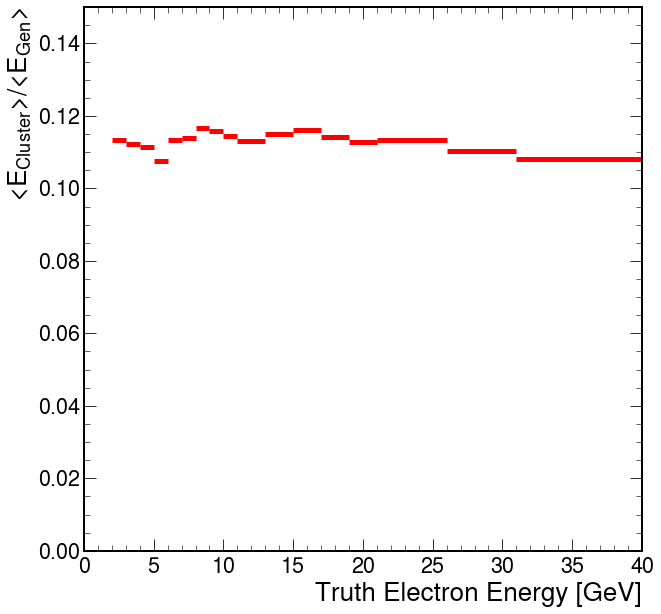

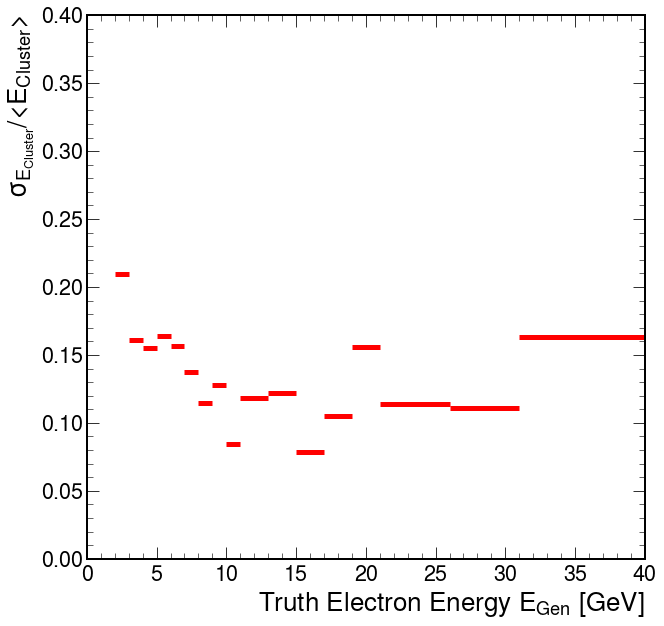

In [206]:
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
print(bin_means)
print(bin_centers)
plt.figure()
plt.hlines(bin_means/bin_centers, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.xlim(0,40.0)
plt.ylim(0,0.15)
plt.xlabel('Truth Electron Energy [GeV]')
plt.ylabel('<$E_{Cluster}$>/<$E_{Gen}$>')
plt.figure()
plt.hlines(bin_resols/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.xlim(0,40.0)
plt.ylim(0,0.4)
plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')

In [137]:
print(len(bin_centers))
print(len(bin_resols/bin_means))
from scipy import optimize
fitfunc = lambda p, x: p[0] + p[1]/ np.sqrt(x)
#fitfunc = lambda p, x: p[0] + p[1] * x
#errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

#pinit = [1.0, -1.0]
#out = optimize.leastsq(fitfunc, pinit,
#                       args=(np.array(bin_centers), np.array(bin_resols/bin_means)), full_output=1)
optimize.leastsq(fitfunc, [0.01, 0.1], args=(bin_centers, bin_resols/bin_means))

20
20


TypeError: <lambda>() takes 2 positional arguments but 3 were given

[0.01259067 0.11530885 0.26051013 0.39551964 0.50369751 0.59482727
 0.73308105 0.80897783 0.95107083 1.08121377 1.19155709 1.29001688
 1.36559631 1.51459113 1.63992932 1.70592344 1.85743949 1.88901926
 2.05436464 2.14129298 2.26810629 2.59034889 2.94713372 3.70015954
 4.95741916]
[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 23.5, 28.5, 36.0, 46.0]


Text(0, 1, '$\\sigma_{E_{EMCal}}$/<$E_{EMCal}$>')

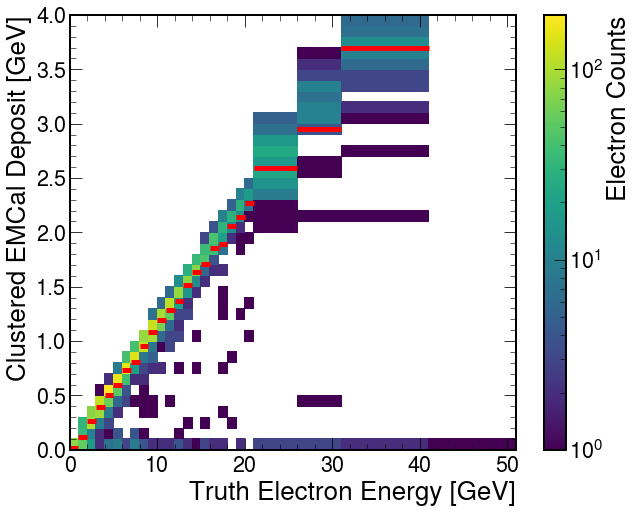

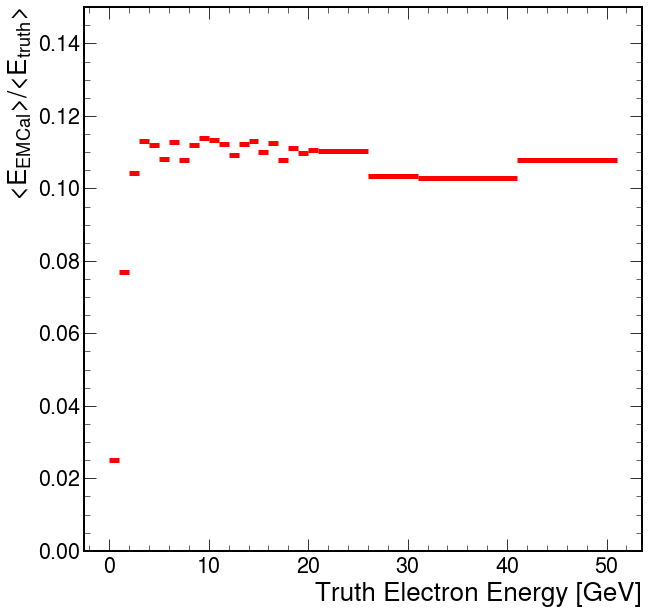

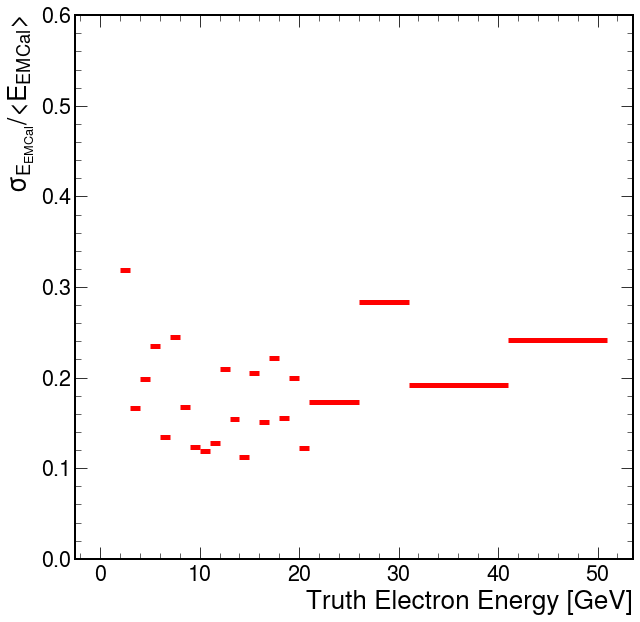

In [109]:
#print(electron_truth)
from scipy.stats import binned_statistic
fig = plt.figure(figsize=(10,8))
binnings = np.concatenate((np.linspace(0,20,num=21), np.linspace(21,31,num=3), np.linspace(41, 51, num=2)))
bin_resols, bin_edges, binnumber = binned_statistic(electron_truth_max+electron_truth_min, cluster_truth_max+cluster_truth_min, statistic='std', bins=binnings, range=(0,40))
bin_means, bin_edges, binnumber = binned_statistic(electron_truth_max+electron_truth_min, cluster_truth_max+cluster_truth_min, statistic='mean', bins=binnings, range=(0,40))
plt.hist2d(electron_truth_max+electron_truth_min, cluster_truth_max+cluster_truth_min, bins=[binnings,40], range=[[0,40], [0,4]], density=False, norm=colors.LogNorm())
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
#plt.xlim(0,8)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_GenElectron_Energy.png")

bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
print(bin_means)
print(bin_centers)
plt.figure()
plt.hlines(bin_means/bin_centers, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.ylim(0,0.15)
plt.xlabel('Truth Electron Energy [GeV]')
plt.ylabel('<$E_{EMCal}$>/<$E_{truth}$>')
plt.figure()
plt.hlines(bin_resols/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.ylim(0,0.6)
plt.xlabel('Truth Electron Energy [GeV]')
plt.ylabel('$\sigma_{E_{EMCal}}$/<$E_{EMCal}$>')

Text(0, 1, 'Clustered EMCal Size')

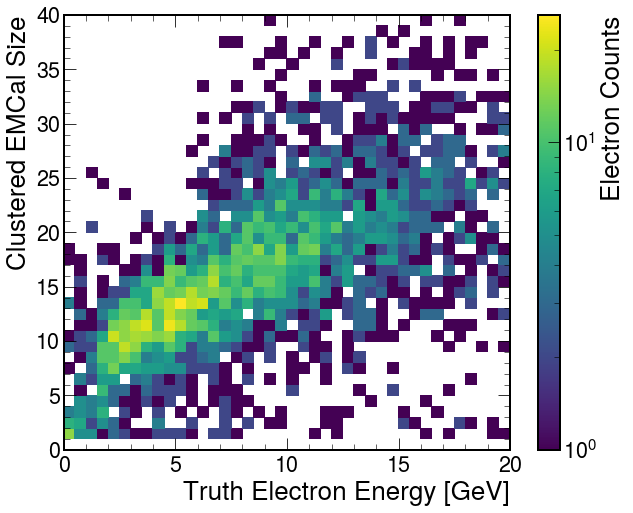

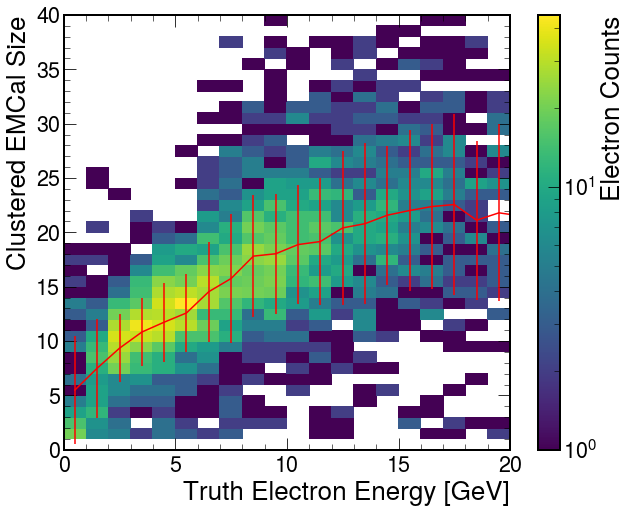

In [214]:
fig = plt.figure(figsize=(10,8))
plt.hist2d(electron_truth_max+ electron_truth_min, cluster_size_max+cluster_size_min, bins=[40,40], range=[[0,20], [0,40]], density=False, norm=colors.LogNorm())
#plt.xlim(0,8)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Size")
plt.savefig("RecoSize_VS_Gen_Energy.png")

from scipy.stats import binned_statistic
fig = plt.figure(figsize=(10,8))
binnings = np.concatenate((np.linspace(0,20,num=21), np.linspace(21,31,num=3), np.linspace(41, 51, num=2)))
bin_resols, bin_edges, binnumber = binned_statistic(electron_truth_max+electron_truth_min, cluster_size_max+cluster_size_min, statistic='std', bins=binnings, range=(0,40))
bin_means, bin_edges, binnumber = binned_statistic(electron_truth_max+electron_truth_min, cluster_size_max+cluster_size_min, statistic='mean', bins=binnings, range=(0,40))
plt.hist2d(electron_truth_max+electron_truth_min, cluster_size_max+cluster_size_min, bins=[binnings,40], range=[[0,20], [0,40]], density=False, norm=colors.LogNorm())
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
#           label='binned statistic of data', linestyles='solid')
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
plt.errorbar(bin_centers, bin_means, bin_resols,color='r')
plt.xlim(0,20)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Size")
#plt.savefig("Reco_VS_GenElectron_Energy.png")

In [26]:
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.613515_z500_600_eps_-6.root"
acc = printemcalshowers_byevent(ifileBrem)
print("acc: ", acc, len(acc))

# this reconstructs preliminary clusters
sample2_electron_truth_max = [] # electron truth energy from production
sample2_electron_truth_min = []
sample2_cluster_truth_max = []
sample2_cluster_truth_min = []
sample2_cluster_reco_max = []
sample2_cluster_reco_min = []
sample2_cluster_size_max = []
sample2_cluster_size_min = []

for evt in acc:
    #if evt > 100:
    #    continue
    #evt = acc[ievt] 
    if len(sample2_cluster_size_max)%10 == 0:
        print("processed ", len(sample2_cluster_size_max), "events")
    ge, showers, energies, sizes = CheckEvent(ifileBrem,evt)
    #print("electron energies: ", ge)
    #print("showers: ", showers)
    #print("energies: ", energies)
    #print("sizes: ", sizes)
    sample2_electron_truth_max.append(max(ge))
    sample2_electron_truth_min.append(min(ge))
    sample2_cluster_truth_max.append(max(showers))
    sample2_cluster_truth_min.append(min(showers))
    sample2_cluster_reco_max.append(max(energies))
    sample2_cluster_reco_min.append(min(energies))
    sample2_cluster_size_max.append(sizes[np.argmax(energies)])
    sample2_cluster_size_min.append(sizes[np.argmin(energies)])
    #break

Fraction of events with two showers reaching EMCAL:  0.105
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [2, 8, 10, 15, ... 9947, 9951, 9979] type='1050 * int64'>,)
acc:  [2, 8, 10, 15, 21, 33, 50, 56, ... 9837, 9857, 9866, 9890, 9920, 9947, 9951, 9979] 1050
processed  0 events
processed  10 events
processed  20 events
processed  30 events
processed  40 events
processed  50 events
processed  60 events
processed  70 events
processed  80 events
processed  90 events
processed  100 events
processed  110 events
processed  120 events
processed  130 events
processed  140 events
processed  150 events
processed  160 events
processed  170 events
processed  180 events
processed  190 events
processed  200 events
processed  210 events
processed  220 events
processed  230 events
processed  240 events
processed  250 events
processed  260 events
processed  270 events
processed  280 events
processed  290 events
processed  300 events
processed  310 

/seaquest/users/yfeng/anaconda3/envs/emcluster/lib/python3.8/site-packages/sklearn/cluster/_birch.py:646: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  warnings.warn(


processed  570 events
processed  580 events
processed  590 events
processed  600 events
processed  610 events
processed  620 events
processed  630 events
processed  640 events
processed  650 events
processed  660 events
processed  670 events
processed  680 events
processed  690 events
processed  700 events
processed  710 events
processed  720 events
processed  730 events
processed  740 events
processed  750 events
processed  760 events
processed  770 events
processed  780 events
processed  790 events
processed  800 events
processed  810 events
processed  820 events
processed  830 events
processed  840 events
processed  850 events
processed  860 events
processed  870 events
processed  880 events
processed  890 events
processed  900 events
processed  910 events
processed  920 events
processed  930 events
processed  940 events
processed  950 events
processed  960 events
processed  970 events
processed  980 events
processed  990 events
processed  1000 events
processed  1010 events
processe

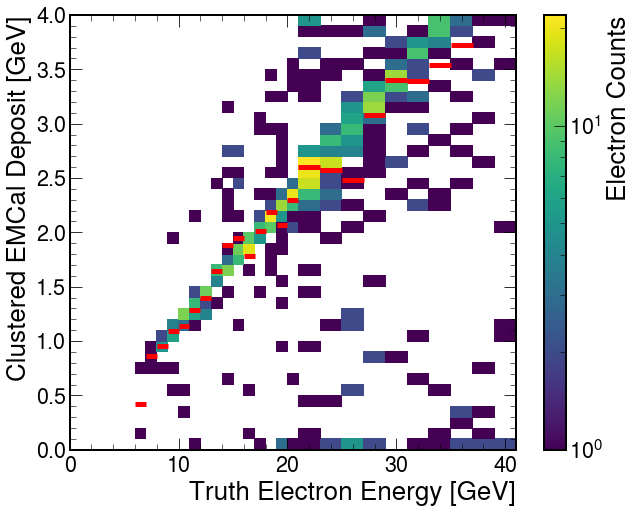

In [102]:
# analysis the output and make plots

#print(electron_truth)
from scipy.stats import binned_statistic
fig = plt.figure(figsize=(10,8))
binnings = np.concatenate((np.linspace(0,20,num=21), np.linspace(21,41,num=11)))
bin_resols, bin_edges, binnumber = binned_statistic(sample2_electron_truth_max, sample2_cluster_reco_max, statistic='std', bins=binnings, range=(0,40))
bin_means, bin_edges, binnumber = binned_statistic(sample2_electron_truth_max, sample2_cluster_reco_max, statistic='mean', bins=binnings, range=(0,40))
plt.hist2d(sample2_electron_truth_max, sample2_cluster_reco_max, bins=[binnings,40], range=[[0,40], [0,4]], density=False, norm=colors.LogNorm())
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
#plt.xlim(0,8)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_GenElectron_Energy.png")

[       nan        nan        nan        nan        nan        nan
 0.42013479 0.8613222  0.95108242 1.09053024 1.14251509 1.28948741
 1.40005833 1.6479337  1.88164039 1.94839434 1.7847611  2.01267777
 2.188699   2.06535684 2.29669262 2.60297585 2.57475134 2.47954489
 3.08222815 3.40043642 3.38776998 3.54250396 3.72343074 4.18295561
 4.23658175]
[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0]


Text(0, 1, '$\\sigma_{E_{EMCal}}$/<$E_{EMCal}$>')

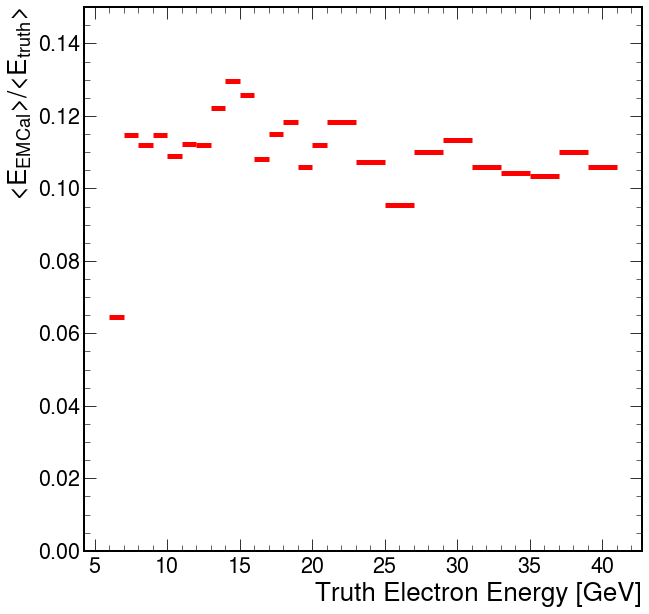

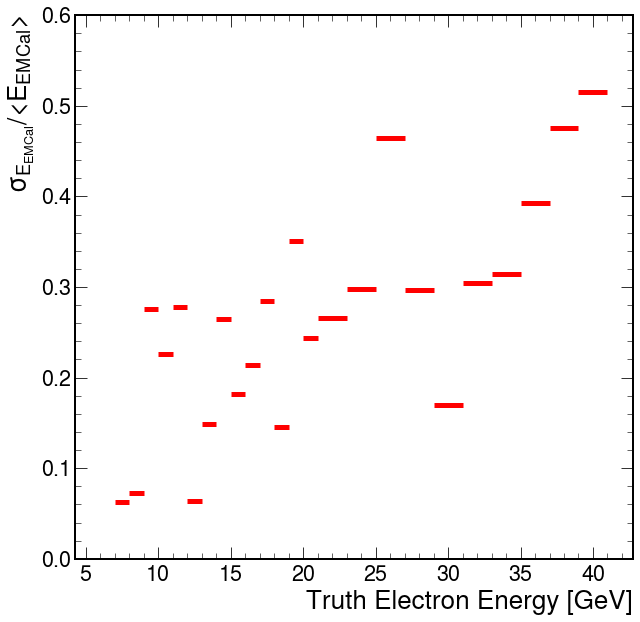

In [103]:
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
print(bin_means)
print(bin_centers)
plt.figure()
plt.hlines(bin_means/bin_centers, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.ylim(0,0.15)
plt.xlabel('Truth Electron Energy [GeV]')
plt.ylabel('<$E_{EMCal}$>/<$E_{truth}$>')
plt.figure()
plt.hlines(bin_resols/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.ylim(0,0.6)
plt.xlabel('Truth Electron Energy [GeV]')
plt.ylabel('$\sigma_{E_{EMCal}}$/<$E_{EMCal}$>')

In [87]:
ifile="/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Eta_0.055176_z500_600_eps_-6.root"
evtNum=0
dq_events = getData(ifile,"Truth")
dq_hits = dq_events["Hits"]
dq_electrons = dq_events["Electrons"]
dq_electrons
dq_showers = dq_events["Showers"]

In [99]:
dq_showers.sedep_ecal[5]
ak.pad_none(dq_electrons.ge, 2, axis=1)[1]

<Array [1.05, 0.0331] type='2 * ?float32'>